## Assignment 3

#### Import Libraries

In [ ]:
import os
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import requests
import csv
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from matplotlib.lines import Line2D


warnings.simplefilter(action='ignore', category=FutureWarning)

#### Import Data / Data Preparation

In [2]:
def read_stations(year, month):
    station_path = os.path.join("stations", year, month)
    all_merged_data = []

    # Check if the station folder exists; if not, return an empty DataFrame
    if not os.path.exists(station_path):
        print(f"Station path {station_path} does not exist.")
        return pd.DataFrame()  # Return empty DataFrame if folder is missing

    # Iterate through all station files in the folder
    for station_file in os.listdir(station_path):
        if station_file.endswith(".csv"):
            station_data = pd.read_csv(os.path.join(station_path, station_file))

            # Filter for Dortmund stations and exclude unwanted stations
            station_data = station_data[
                (station_data['city'] == "Dortmund") &  # Only include stations in Dortmund
                (~station_data['name'].str.contains("BAB|BAT|Autobahntankstelle", case=False, na=False))  # Exclude highway stations
            ]

            # Extract the date from the station file name
            date_in_file = station_file.split(".")[0].replace("-stations", "")
            # Merge station data with price data for the specific date
            merged_data = read_prices(year, month, date_in_file, station_data)
            all_merged_data.append(merged_data)

    # Combine all merged data into a single DataFrame; return an empty DataFrame if no data is available
    return pd.concat(all_merged_data, ignore_index=True) if all_merged_data else pd.DataFrame()

def read_prices(year, month, date_in_file, station_df):
    price_path = os.path.join("prices", year, month)
    price_file = os.path.join(price_path, f"{date_in_file}-prices.csv")

    # Check if the price file exists; if not, return an empty DataFrame
    if not os.path.exists(price_file):
        print(f"Price file {price_file} does not exist.")
        return pd.DataFrame()  # Return empty DataFrame if file is missing

    # Read price data and convert the 'date' column to datetime
    price_data = pd.read_csv(price_file)
    price_data['date'] = pd.to_datetime(price_data['date'])

    # Merge price data with station data based on 'station_uuid'
    price_data = price_data[['date', 'station_uuid', 'e10', 'e10change']]
    merged_data = pd.merge(price_data, station_df, left_on='station_uuid', right_on='uuid', how='inner')

    # Logic: Keep only the first price and subsequent rows where 'e10change' is 1
    filtered_data = []
    for station_uuid, group in merged_data.groupby('station_uuid'):
        group = group.sort_values('date')  # Sort by date
        first_row = group.iloc[0].to_dict()  # First price as a dictionary
        filtered_data.append(first_row)

        group = group.iloc[1:]  # Skip the first row
        subsequent_rows = group[group['e10change'] == 1].to_dict('records')  # Rows where 'e10change' is 1
        filtered_data.extend(subsequent_rows)

    # Convert the list of dictionaries to a DataFrame
    filtered_data = pd.DataFrame(filtered_data)

    # Fill missing 'e10' prices
    for i in filtered_data.index[filtered_data['e10'] == 0]:
        current_date = filtered_data.at[i, 'date']
        station_uuid = filtered_data.at[i, 'station_uuid']

        print(f"Missing price on {current_date.strftime('%Y-%m-%d')} for station UUID {station_uuid}")
        price_previous_day = find_price_previous_day(current_date, station_uuid)

        # If a valid price from the previous day is found, use it
        if price_previous_day is not None:
            filtered_data.at[i, 'e10'] = price_previous_day['e10']
            print(f"Applied last valid price: {price_previous_day['e10']}")

    # Remove stations with missing prices (where 'e10' is still 0)
    before_removal = len(filtered_data)
    filtered_data = filtered_data[filtered_data['e10'] != 0]
    after_removal = len(filtered_data)
    
    print(f"Removed {before_removal - after_removal} stations with missing prices.")

    return filtered_data

def find_price_previous_day(current_date, station_uuid):
    # Calculate the previous day's date
    previous_day = current_date - timedelta(days=1)
    previous_price_file = os.path.join(
        "prices", str(previous_day.year), f"{previous_day.month:02d}",
        f"{previous_day.year}-{previous_day.month:02d}-{previous_day.day:02d}-prices.csv"
    )

    # Check if the previous day's price file exists
    if not os.path.exists(previous_price_file):
        print(f"Previous price file {previous_price_file} does not exist.")
        return None

    # Read the previous day's price data
    previous_price_data = pd.read_csv(previous_price_file)
    previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])

    # Filter for the same station and a valid price
    previous_price = previous_price_data[
        (previous_price_data['station_uuid'] == station_uuid) &  # Same station
        (previous_price_data['e10'] != 0)  # Valid price
    ]

    # Return the most recent price for the station
    return previous_price.sort_values('date', ascending=False).iloc[0] if not previous_price.empty else None

result = []

for year in ["2023", "2024"]:
    months = ["11", "12"] if year == "2023" else [f"{i:02d}" for i in range(1, 11)]

    for month in months:
        # Read station and price data for the year and month
        price_data = read_stations(year, month)
        if not price_data.empty:
            result.append(price_data)

final_df = pd.concat(result, ignore_index=True) if result else pd.DataFrame()


Missing price on 2023-11-01 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2023-11-01 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2023-11-01 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2023-11-01 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 4 stations with missing prices.
Missing price on 2023-11-02 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2023-11-02 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2023-11-02 for station UUID 5915ebc0-e19e-47b8-bfce-0fbb3234ab54
Missing price on 2023-11-02 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2023-11-02 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 5 stations with missing prices.
Missing price on 2023-11-03 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2023-11-03 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2

In [3]:
final_df = final_df.drop(['uuid'], axis=1)
final_df['date'] = pd.to_datetime(final_df['date'], utc=True)
final_df['date'] = final_df['date'].dt.tz_localize(None)

final_df.head(5)

,date,station_uuid,e10,e10change,name,brand,street,house_number,post_code,city,latitude,longitude,first_active,openingtimes_json
0,2023-11-01 03:23:46,005056ba-7cb6-1ed2-bceb-57e186e40d16,1.749,1,star Tankstelle,STAR,Evinger Straße,517,44339,Dortmund,51.573735,7.464103,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
1,2023-11-01 04:13:47,005056ba-7cb6-1ed2-bceb-57e186e40d16,1.739,1,star Tankstelle,STAR,Evinger Straße,517,44339,Dortmund,51.573735,7.464103,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
2,2023-11-01 04:53:10,005056ba-7cb6-1ed2-bceb-57e186e40d16,1.769,1,star Tankstelle,STAR,Evinger Straße,517,44339,Dortmund,51.573735,7.464103,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
3,2023-11-01 05:53:38,005056ba-7cb6-1ed2-bceb-57e186e40d16,1.829,1,star Tankstelle,STAR,Evinger Straße,517,44339,Dortmund,51.573735,7.464103,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
4,2023-11-01 06:28:30,005056ba-7cb6-1ed2-bceb-57e186e40d16,1.819,1,star Tankstelle,STAR,Evinger Straße,517,44339,Dortmund,51.573735,7.464103,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."


#### Price pattern per hour and per day. 

In [4]:
final_df['hour'] = final_df['date'].dt.hour
final_df['day_of_week'] = final_df['date'].dt.day_name()

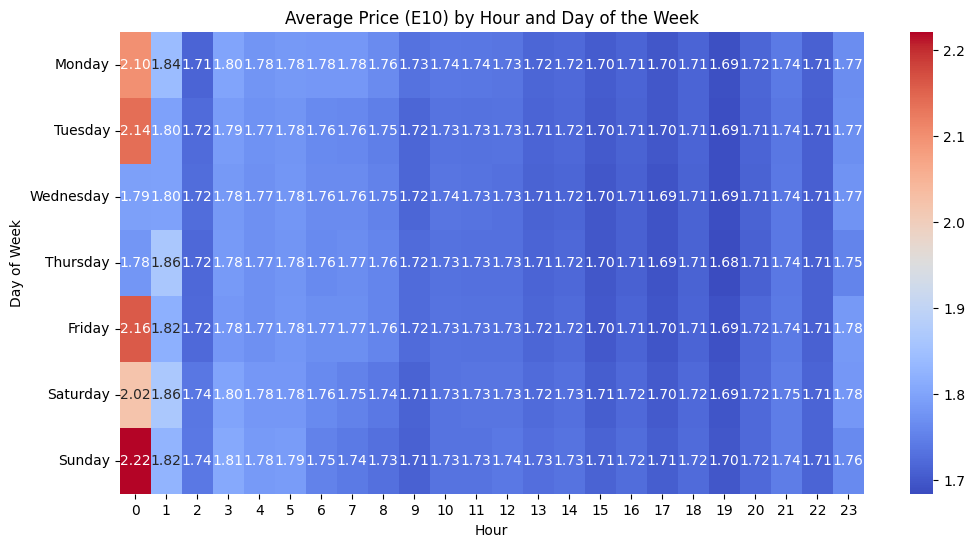

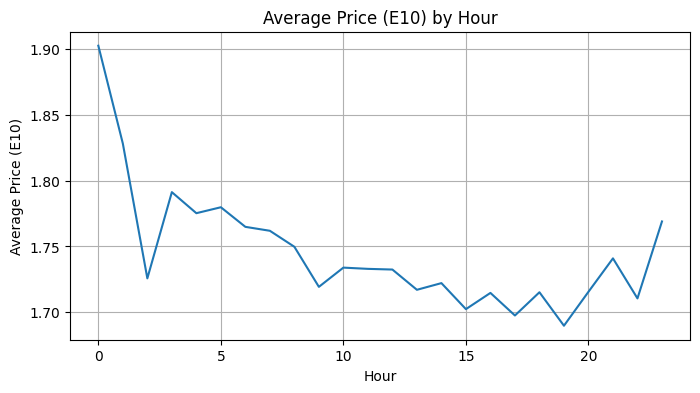

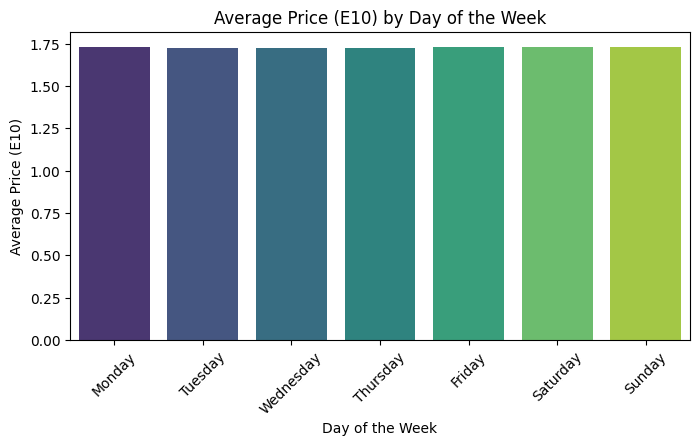

In [5]:
hourly_pattern = final_df.groupby('hour')['e10'].mean().reset_index()
daily_pattern = final_df.groupby('day_of_week')['e10'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

heatmap_data = final_df.groupby(['day_of_week', 'hour'])['e10'].mean().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average Price (E10) by Hour and Day of the Week")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(8, 4))
sns.lineplot(data=hourly_pattern, x='hour', y='e10')
plt.title("Average Price (E10) by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Price (E10)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=daily_pattern.index, y=daily_pattern.values, palette="viridis")
plt.title("Average Price (E10) by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Price (E10)")
plt.xticks(rotation=45)
plt.show()


#### Price deviations per brand

                                 mean       std
brand                                          
Klink                        1.662969  0.044337
Calpam                       1.666225  0.038844
GO                           1.702266  0.049361
OIL!                         1.706580  0.068692
Q1                           1.707409  0.067284
STAR                         1.708207  0.068696
HEM                          1.708476  0.069320
T Xpress                     1.708884  0.072432
SB                           1.708912  0.068602
Tankstation Oespel (Calpam)  1.710893  0.071142
Markant (Tankautomat)        1.711586  0.068664
ORLEN                        1.712779  0.068762
Markant                      1.713573  0.067574
Classic Tankstelle           1.714309  0.071570
Bavaria Petrol               1.715838  0.069408
BFT                          1.718054  0.070202
BFT Tankstelle               1.720046  0.072188
Mr. Wash Autoservice AG      1.721239  0.067447
T                            1.721929  0

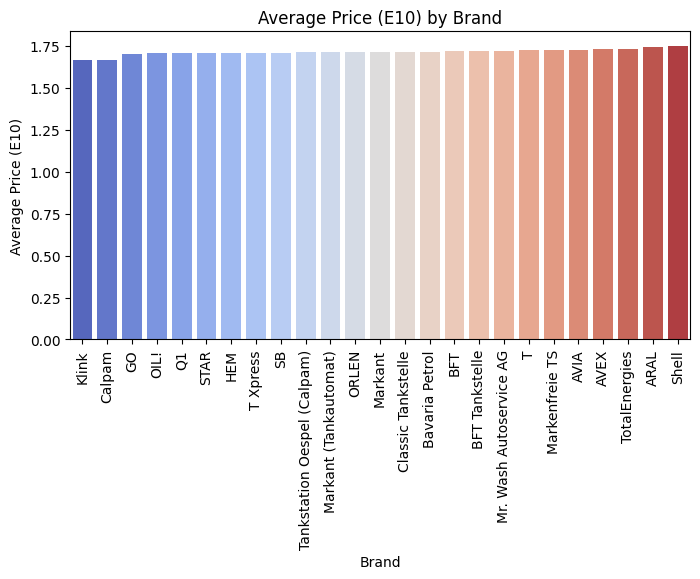

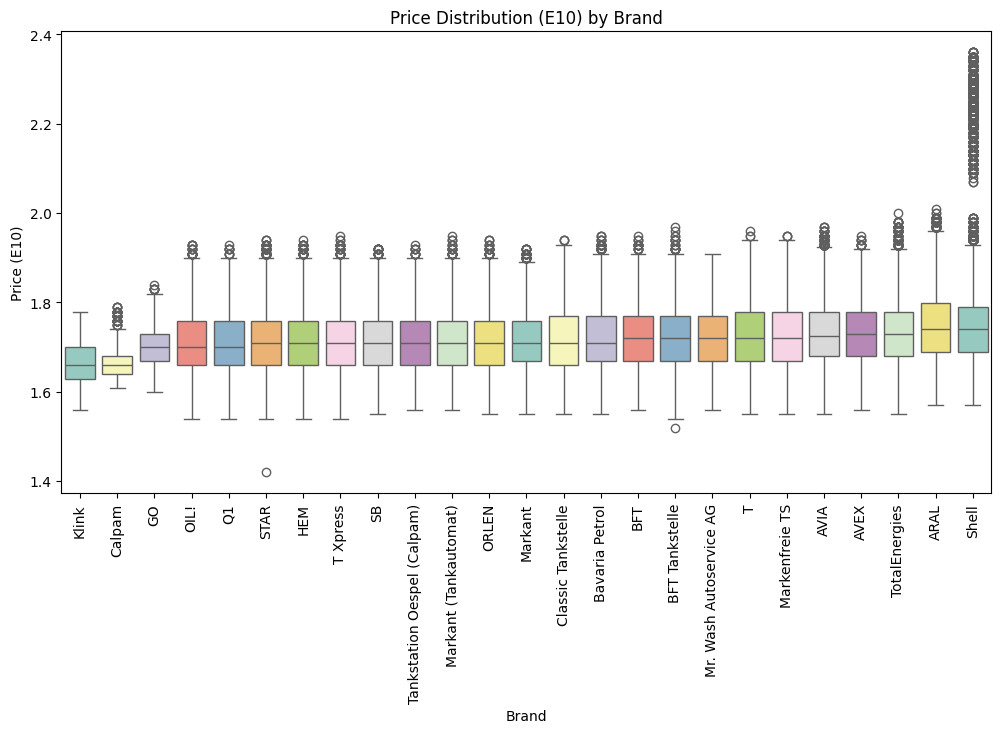

In [6]:
brand_stats = final_df.groupby('brand')['e10'].agg(['mean', 'std']).sort_values('mean', ascending=True)

print(brand_stats)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=brand_stats.reset_index(),
    x='brand',
    y='mean',
    order=brand_stats.index, 
    palette="coolwarm"
)
plt.title("Average Price (E10) by Brand")
plt.xlabel("Brand")
plt.ylabel("Average Price (E10)")
plt.xticks(rotation=90) 
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=final_df,
    x='brand',
    y='e10',
    order=brand_stats.index, 
    palette="Set3"
)
plt.title("Price Distribution (E10) by Brand")
plt.xlabel("Brand")
plt.ylabel("Price (E10)")
plt.xticks(rotation=90)  
plt.show()

#### School Holidays

In [113]:
# List for the state of NRW (DE-NW)
states = [
    ("DE-NW", 3069, 18190422),  # NRW
]

# List to store results (CSV data)
results = [] 
results.append(("stateId", "stateISO", "day"))  # Header for CSV file

# Function to fetch and store vacation days for NRW
def write_results(stateId, stateISO, year):
    url = f'https://www.feiertagskalender.ch/ferien.php?geo={stateId}&jahr={year}&klasse=0&hl=en'
    response = requests.get(url)
    
    if response.status_code == 200:
        print(f"Successfully retrieved data for {stateISO} in the year {year}.")
        soup = BeautifulSoup(response.text, 'html.parser')
        body = soup.find('table', {"id": "school_vacancies"})
        
        if body:
            rows = body.find_all('tr')
            for row in rows:
                cell = row.find_all('td')
                if cell:
                    try:
                        # Start and end date of the vacation
                        start_date = datetime.strptime(cell[0].text.strip(), '%d.%m.%Y').date()
                        end_date = start_date
                        if cell[3].text.strip():
                            end_date = datetime.strptime(cell[3].text.strip(), '%d.%m.%Y').date()
                        
                        # Record all the days between the start and end date
                        delta = end_date - start_date
                        for i in range(delta.days + 1):
                            day = start_date + timedelta(days=i)
                            results.append((stateId, stateISO, day))
                    except Exception as e:
                        print(f"Error processing the row: {e}")
    else:
        print(f"Error retrieving data for {stateISO} in the year {year}")

# Fetch vacation days for 2023 and 2024
write_results(3069, "DE-NW", 2023)
write_results(3069, "DE-NW", 2024)

# Save the results to a CSV file
with open("test_nrw.csv", "wt", newline='') as fp:
    writer = csv.writer(fp, delimiter=",")
    writer.writerows(results)

# Read the CSV file
vacation_days = []

# Read vacation days from the CSV file
with open("test_nrw.csv", newline='') as fp:
    reader = csv.reader(fp, delimiter=",", quotechar='"')
    next(reader, None)  # Skip header row
    data_read = [row for row in reader]

    # Convert the days to a date format
    for day in data_read:
        try:
            day_date = datetime.strptime(day[2], '%Y-%m-%d').date()
            vacation_days.append(day_date)
        except Exception as e:
            print(f"Error converting {day[2]}: {e}")

Successfully retrieved data for DE-NW in the year 2023.
Successfully retrieved data for DE-NW in the year 2024.


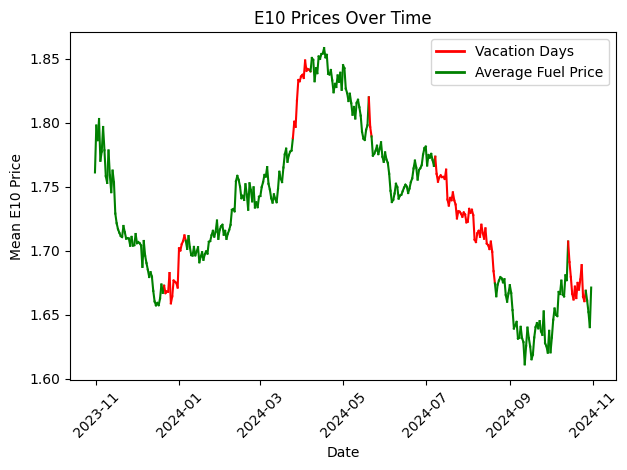

In [114]:
# Copy of final_df (assuming final_df is already defined elsewhere in your code)
final_df_copy = final_df
final_df_copy['date'] = pd.to_datetime(final_df_copy['date'])
final_df_copy['date_only'] = final_df_copy['date'].dt.date

# Calculate the mean fuel prices for each day
mean_prices = final_df.groupby('date_only')['e10'].mean().reset_index()

# Plot the fuel prices, highlighting vacation days in red
for i in range(len(mean_prices) - 1):
    current_day = mean_prices['date_only'].iloc[i]
    next_day = mean_prices['date_only'].iloc[i + 1]
    
    # Check if the current day is a vacation day
    if current_day in vacation_days:
        plt.plot([current_day, next_day], [mean_prices['e10'].iloc[i], mean_prices['e10'].iloc[i + 1]], color='red', zorder=5)
    else:
        plt.plot([current_day, next_day], [mean_prices['e10'].iloc[i], mean_prices['e10'].iloc[i + 1]], color='green', zorder=5)

vacation_legend = Line2D([0], [0], color='red', lw=2, label='Vacation Days')
regular_legend = Line2D([0], [0], color='green', lw=2, label='Average Fuel Price')

plt.xlabel('Date')
plt.ylabel('Mean E10 Price')
plt.title('E10 Prices Over Time')
plt.legend(handles=[vacation_legend, regular_legend])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Crued Oil-Price Impacts

[*********************100%***********************]  1 of 1 completed

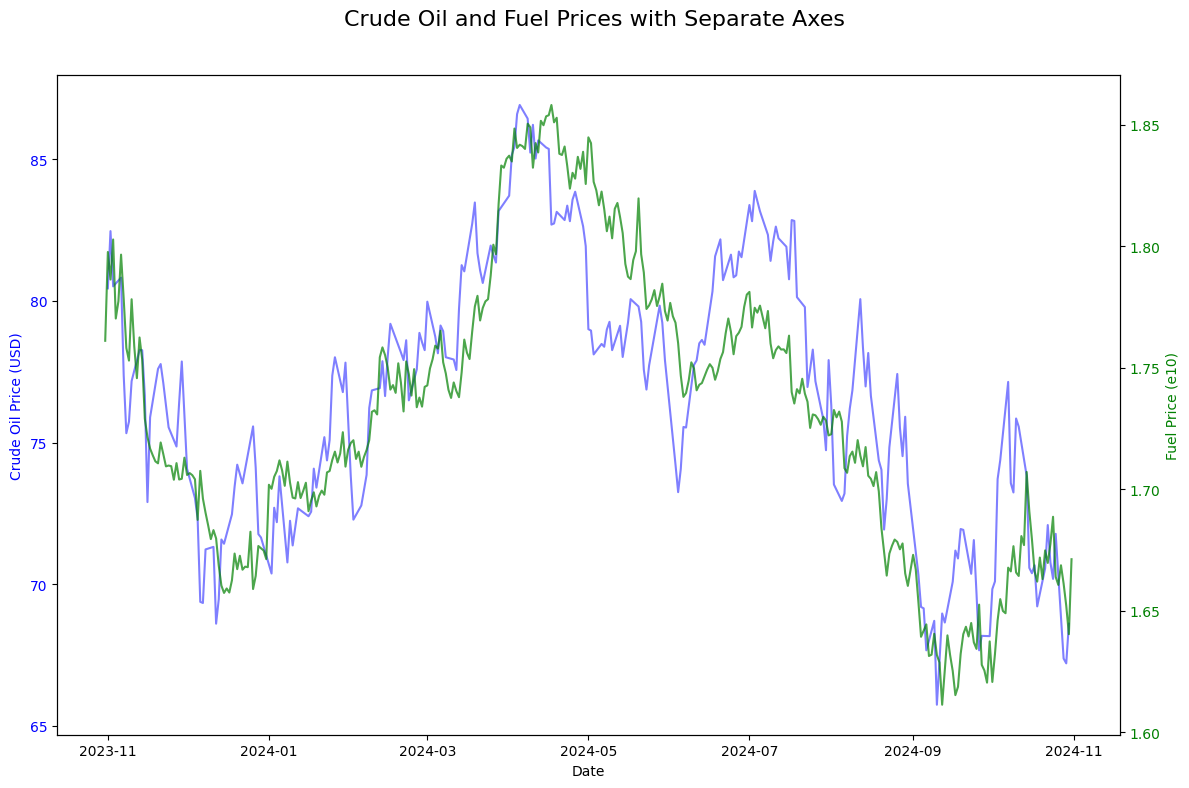

In [177]:
stocks = ["CL=F"]
start_date = "2023-11-01"
end_date = "2024-10-31"

crude_oil_data = yf.download(stocks, start=start_date, end=end_date)
final_df_copy = final_df
final_df_copy['date'] = pd.to_datetime(final_df['date'])
final_df_copy = final_df_copy.set_index('date')

daily_mean_prices = final_df_copy['e10'].resample('D').mean()

scaler = MinMaxScaler()
crude_oil_data['Close_normalized'] = scaler.fit_transform(crude_oil_data[['Close']])
daily_mean_prices_normalized = scaler.fit_transform(daily_mean_prices.values.reshape(-1, 1))

def plot_secondary_y_axis():
    fig, ax1 = plt.subplots(figsize=(12, 8))
    fig.suptitle('Crude Oil and Fuel Prices with Separate Axes', fontsize=16)
    ax1.plot(crude_oil_data.index, crude_oil_data['Close'], label='Crude Oil Price', color='blue', alpha=0.5)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Crude Oil Price (USD)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.plot(daily_mean_prices.index, daily_mean_prices, label='Fuel Prices (e10)', color='green', alpha=0.7)
    ax2.set_ylabel("Fuel Price (e10)", color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    fig.tight_layout(rect=(0, 0, 1, 0.96))
    plt.show()


plot_secondary_y_axis() 


[*********************100%***********************]  1 of 1 completed


Correlation Matrix (Percentage Changes):
            crude_oil  fuel_price
crude_oil    1.000000   -0.019786
fuel_price  -0.019786    1.000000


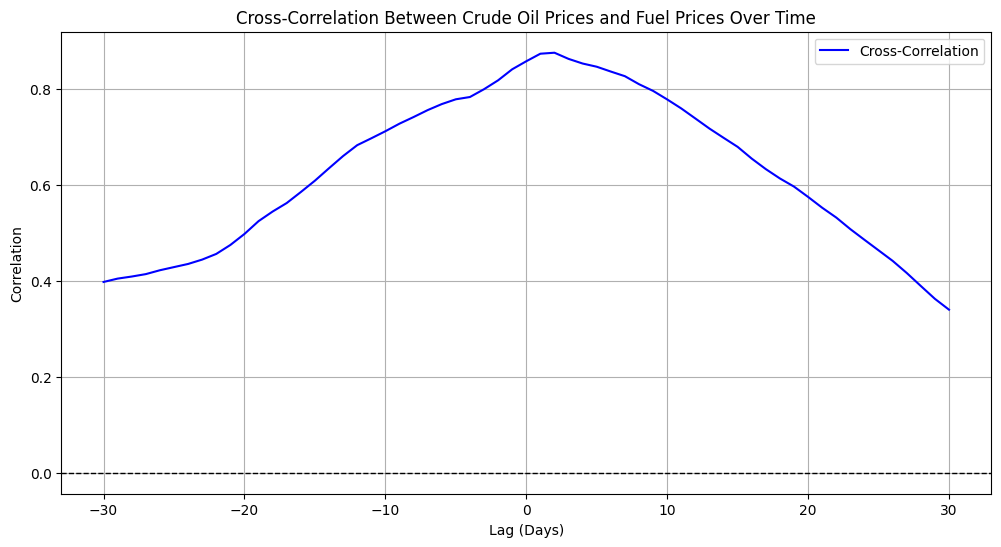

The highest correlation occurs at a lag of 2 days.


In [ ]:
stocks = ["CL=F"]
start_date = "2023-11-01"
end_date = "2024-10-31"

crude_oil_data = yf.download(stocks, start=start_date, end=end_date)

# Assuming final_df contains daily average fuel prices (e10)
final_df_copy = final_df
final_df_copy['date'] = pd.to_datetime(final_df['date'])
final_df_copy = final_df_copy.set_index('date')

# Calculating daily mean fuel prices (e10)
daily_mean_prices = final_df_copy['e10'].resample('D').mean()

scaler = MinMaxScaler()

crude_oil_data['Close_normalized'] = scaler.fit_transform(crude_oil_data[['Close']])
daily_mean_prices_normalized = scaler.fit_transform(daily_mean_prices.values.reshape(-1, 1))

crude_oil_data.index = crude_oil_data.index.tz_convert('US/Eastern')  # Ensure it's in US Eastern first
crude_oil_data.index = crude_oil_data.index.tz_convert('UTC')  # Convert to UTC
daily_mean_prices.index = pd.to_datetime(daily_mean_prices.index).tz_localize('UTC')

daily_mean_prices = daily_mean_prices.squeeze()
crude_oil_prices = crude_oil_data['Close'].squeeze()

analysis_data = pd.DataFrame({
    'crude_oil': crude_oil_prices,
    'fuel_price': daily_mean_prices
}).dropna()

# Calculate percentage changes
analysis_data_pct = analysis_data.pct_change().dropna()
correlation = analysis_data_pct.corr()

print("Correlation Matrix (Percentage Changes):")
print(correlation)

# Function to calculate cross-correlation (lag correlation) between two time series
def cross_correlation(series1, series2, max_lag=30):
    """
    Calculates the cross-correlation for different lags between two time series.
    """
    correlations = []
    for lag in range(-max_lag, max_lag + 1):  # Lags from -max_lag to +max_lag
        shifted_series = series1.shift(lag)
        correlation = shifted_series.corr(series2)
        correlations.append(correlation)
    return correlations

#Calculating cross-correlation for various lags
max_lag = 30 
correlations = cross_correlation(crude_oil_prices, daily_mean_prices, max_lag)
lags = np.arange(-max_lag, max_lag + 1)

plt.figure(figsize=(12, 6))
plt.plot(lags, correlations, label="Cross-Correlation", color='blue')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title("Cross-Correlation Between Crude Oil Prices and Fuel Prices Over Time")
plt.xlabel("Lag (Days)")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend()
plt.show()

#Determining the lag with the highest correlation
max_correlation_lag = lags[np.argmax(correlations)]
print(f"The highest correlation occurs at a lag of {max_correlation_lag} days.")


#### Comparison between stations